In [1]:
# This is literally just stuff I did in Google Collab because model training on CPU was slow asf
# see https://colab.research.google.com/drive/1RKtOwvqVxl2oh9dcXuI-Qt40rna1CqIV?usp=sharing for model

In [2]:
import numpy as np
from tensorflow import keras
import torch
from torch import nn
import torchvision
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

transform = torchvision.transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)
# import data and load
train_data = torchvision.datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=transform
)

test_data = torchvision.datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=transform
)

100%|██████████| 170498071/170498071 [00:12<00:00, 13155095.53it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [3]:
class_names = train_data.classes
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [43]:
class ImageModel(nn.Module):
    """
    CNN model for CIFAR dataset
    """
    def __init__(self, input_shape:int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1
                      ),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(
                in_features=hidden_units * 8 * 8,
                out_features=84
            ),
            nn.ReLU(),
            nn.Linear(
                in_features=84,
                out_features=output_shape
            )
        )

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        x = self.block_2(x)
        return self.classifier(x)

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [46]:
class ModelTrainer():
    def __init__(
            self, 
            optimizer=None,
            loss_fn = None,
            epochs=3,
            batch_size=32,
            logging=True,
            graph_progress=True,
            seed=42
            ):
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        if (epochs <= 0):
            raise Exception("Must have at least one epoch.")
        self.epochs = epochs
        if (batch_size <= 0):
            raise Exception("Must have batch size > 0.")
        self.batch_size = batch_size
        self.logging = bool(logging)
        self.graph_progress = graph_progress
        self.seed = seed
    
    def set_optimizer(self, optimizer: torch.optim.Optimizer):
        self.optimizer = optimizer
        return self

    def set_loss_function(self, loss_func: torch.nn.Module):
        self.loss_fn = loss_func
        return self
    
    def set_epochs(self, epochs: int):
        if (epochs <= 0):
            raise Exception("Must have at least one epoch.")
        self.epochs = epochs
        return self

    def set_batch_size(self, batch_size: int):
        if (batch_size <= 0):
            raise Exception("Must have batch size > 0.")
        self.batch_size = batch_size
        return self
    
    def set_logging(self, logging: bool):
        self.logging = logging
        return self

    def set_progress_graphing(self, graph_progress: bool):
        self.graph_progress = graph_progress
        return self
    
    def set_random_seed(self, seed: int):
        self.seed = seed
        return self
    
    def log(self, message):
        if (self.logging):
            print(message)
        
    # Calculate accuracy (a classification metric)
    @staticmethod
    def accuracy_fn(y_true, y_pred):
        correct = torch.eq(y_true, y_pred).sum().item()
        acc = (correct / len(y_pred)) * 100
        return acc

    def train(
            self, 
            model: torch.nn.Module, 
            training_data: torch.utils.data.DataLoader, 
            testing_data: torch.utils.data.DataLoader
            ):
        if (self.optimizer is None):
            raise Exception("Optimizer must be defined.")
        if (self.loss_fn is None):
            raise Exception("Loss function must be defined.")
          
        # set up graphing
        epoch_count = []
        training_accs = []
        testing_accs = []
        
        # set up device
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.log(f"Using {device.type}")
        if (device.type == 'cuda'):
          model.cuda()
        
        # get dataloaders from datasets
        train_dataloader = DataLoader(
            training_data, 
            self.batch_size, 
            shuffle=True
        )
        test_dataloader = DataLoader(
            testing_data, 
            self.batch_size, 
            shuffle=False
        )
        model.train()
        
        # training loop
        for epoch in range(self.epochs):
            self.log(f"Epoch {epoch}")
            epoch_count.append(epoch)

            # training loss per batch
            train_loss, train_acc = 0,0

            

            for batch, (X, y) in enumerate(train_dataloader):
                # forward pass
                if device.type == 'cuda':
                  X, y = X.cuda(), y.cuda()
                y_pred = model(X)

                # calculate loss
                loss = self.loss_fn(y_pred, y)
                train_loss += loss.item()

                self.optimizer.zero_grad()
                # print(y,
                #     y_pred.argmax(dim=1))
                train_acc += ModelTrainer.accuracy_fn(
                    y_true=y,
                    y_pred=y_pred.argmax(dim=1)
                )

                # loss backward
                loss.backward()


                # optimizer step
                self.optimizer.step()

                if batch % 100 == 0:
                    self.log(f"Looked at batch {batch}, {batch * len(X)}/{len(train_dataloader.dataset)} samples")
            
            # calclate loss and accuracy per epoch
            train_loss /= len(train_dataloader)
            train_acc /= len(train_dataloader)
            self.log(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")
            training_accs.append(train_acc)

            # test model
            test_loss, test_acc = 0,0
            model.eval()
            with torch.inference_mode():
                for X, y in test_dataloader:
                    X, y = X.cuda(), y.cuda()
                    
                    # forward pass
                    test_pred = model(X)

                    # calculate loss/accuracy
                    test_loss += self.loss_fn(test_pred, y)
                    test_acc += ModelTrainer.accuracy_fn(
                        y_true=y, 
                        y_pred=test_pred.argmax(dim=1)
                    )

                test_loss /= len(test_dataloader)
                test_acc /= len(test_dataloader)
            self.log(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")
            testing_accs.append(test_acc)

        if self.graph_progress:
          plt.plot(epoch_count, training_accs, label="Training Accuracy")
          plt.plot(epoch_count, testing_accs, label="Testing Accuracy")
          plt.title("Training and Test Accuracy")
          plt.ylabel("Accuracy")
          plt.xlabel("Epochs")
          plt.legend()
          plt.show()
        return model

Using cuda
Epoch 0
Looked at batch 0, 0/50000 samples
Looked at batch 100, 2000/50000 samples
Looked at batch 200, 4000/50000 samples
Looked at batch 300, 6000/50000 samples
Looked at batch 400, 8000/50000 samples
Looked at batch 500, 10000/50000 samples
Looked at batch 600, 12000/50000 samples
Looked at batch 700, 14000/50000 samples
Looked at batch 800, 16000/50000 samples
Looked at batch 900, 18000/50000 samples
Looked at batch 1000, 20000/50000 samples
Looked at batch 1100, 22000/50000 samples
Looked at batch 1200, 24000/50000 samples
Looked at batch 1300, 26000/50000 samples
Looked at batch 1400, 28000/50000 samples
Looked at batch 1500, 30000/50000 samples
Looked at batch 1600, 32000/50000 samples
Looked at batch 1700, 34000/50000 samples
Looked at batch 1800, 36000/50000 samples
Looked at batch 1900, 38000/50000 samples
Looked at batch 2000, 40000/50000 samples
Looked at batch 2100, 42000/50000 samples
Looked at batch 2200, 44000/50000 samples
Looked at batch 2300, 46000/50000 s

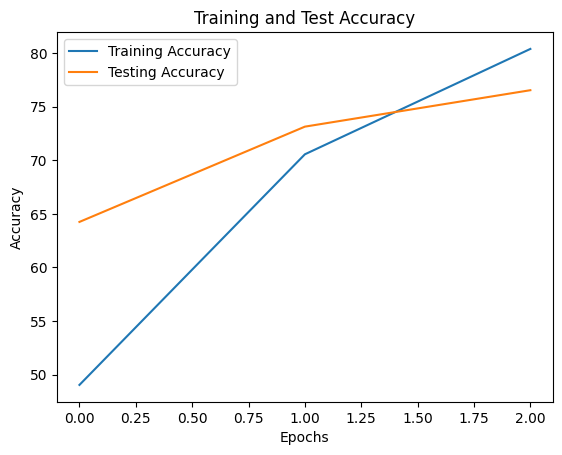

In [48]:
# define model

model = ImageModel(
    input_shape=3, 
    hidden_units=1536, 
    output_shape=len(class_names)
)



# define model trainer params
model_trainer = ModelTrainer()
model_trainer.set_optimizer(torch.optim.SGD(params=model.parameters(), lr=0.0075, momentum=0.85))
model_trainer.set_loss_function(nn.CrossEntropyLoss())
model_trainer.set_epochs(3)
model_trainer.set_logging(True)
model_trainer.set_batch_size(20)

# train model
model_trainer.train(model, testing_data=test_data, training_data=train_data)

# save model to models
torch.save(model.state_dict(), 'models/cifar.pth')




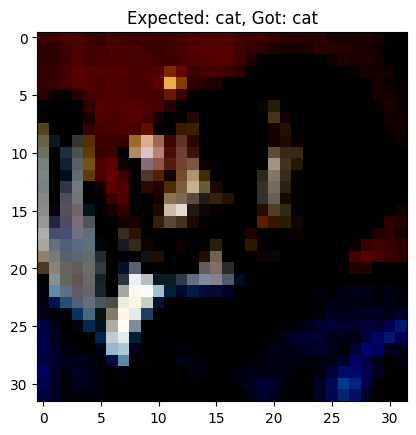

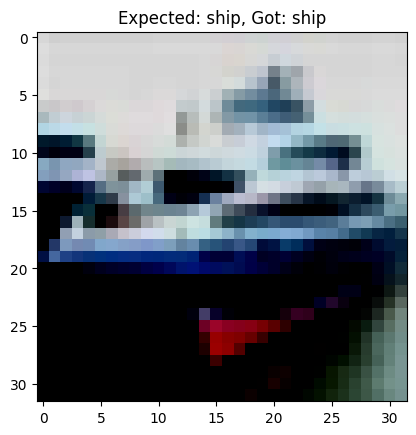

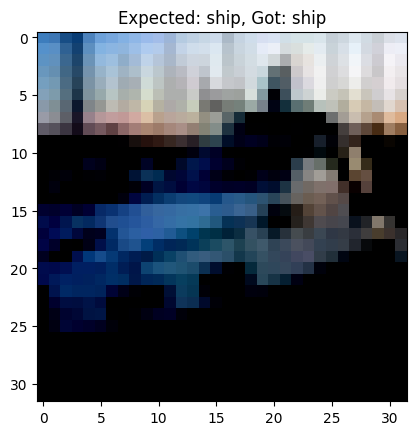

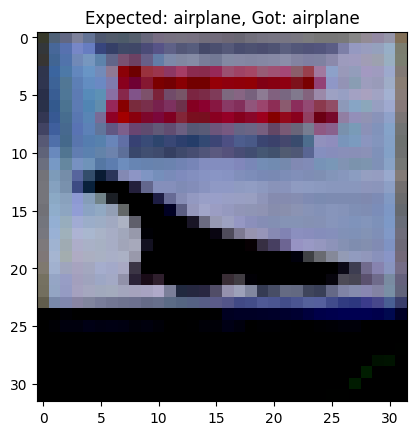

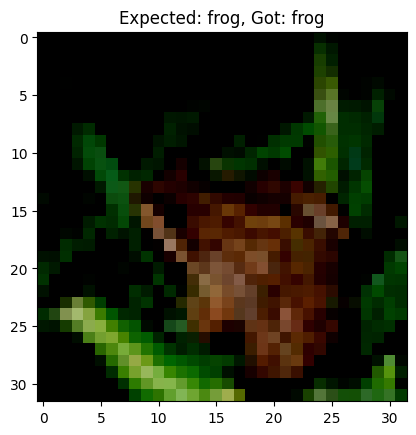

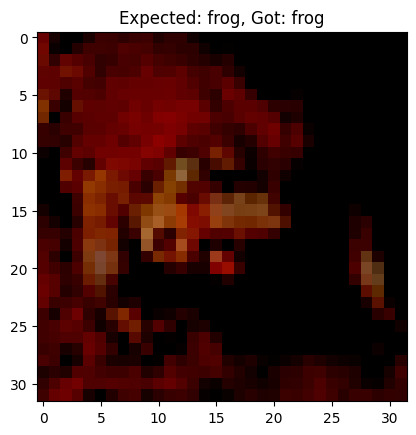

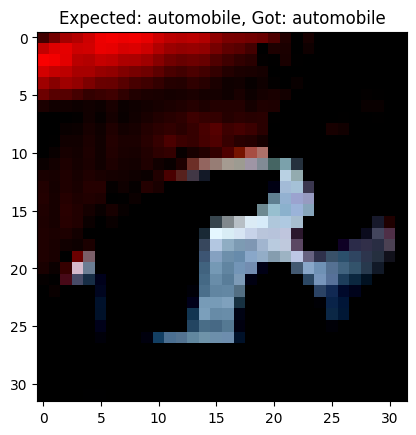

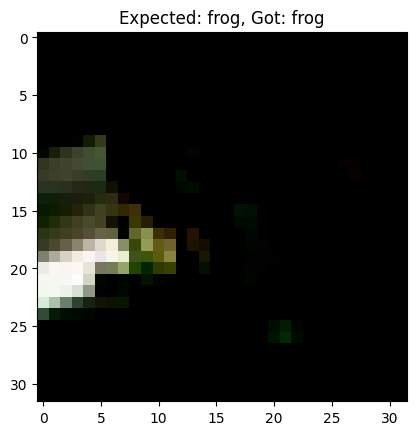

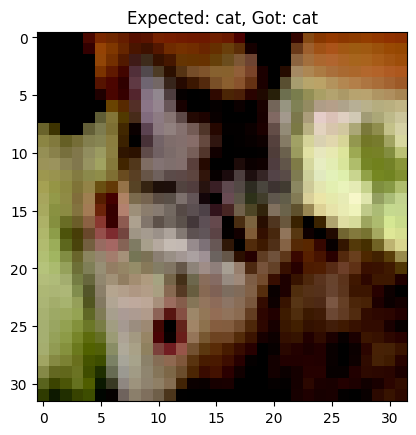

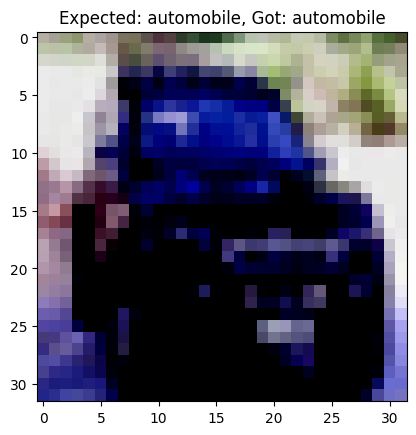

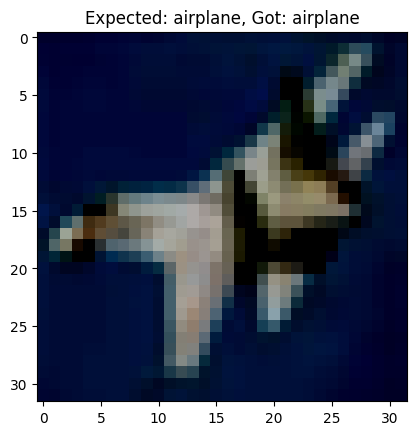

In [54]:
# load model
loaded_model = ImageModel(
    input_shape=3, 
    hidden_units=1536, 
    output_shape=len(class_names)
)
loaded_model.load_state_dict(torch.load('models/cifar.pth'))
loaded_model.eval()

# show images + predictions
with torch.inference_mode():
  data_loader = DataLoader(
            test_data, 
            shuffle=False
        )
  for i, (X, y) in enumerate(data_loader):
    prediction = loaded_model(X).argmax(dim=1)
    plt.title(f"Expected: {class_names[y.item()]}, Got: {class_names[prediction.item()]}")
    plt.imshow(X.squeeze().permute(1, 2, 0))
    plt.show()
    if (i >= 10):
      break
